In [1]:
#basic pacakges
import pandas as pd
import numpy as np

#plotting
import seaborn as sns
import matplotlib.pyplot as plt

#for readin
import glob 
import os   

#nilearn
from nilearn import plotting, image
from nilearn.image import mean_img, concat_imgs
from nilearn.plotting import plot_anat, plot_img, plot_stat_map,\
    show, plot_design_matrix, plot_contrast_matrix
from nilearn.glm import threshold_stats_img
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
from nilearn.reporting import get_clusters_table
from nilearn.maskers import NiftiSpheresMasker

### A Look At the Structure of fMRI Data (Single-Subject, One Run)

In [2]:
run01_img = image.load_img('func/run01/*.nii')
first_run = image.index_img(run01_img, 0)
print(run01_img.shape) # x, y, z, number of scans

(86, 86, 54, 171)


### Single-subject data in native space
#### Display the mean functional image and the subject’s anatomy

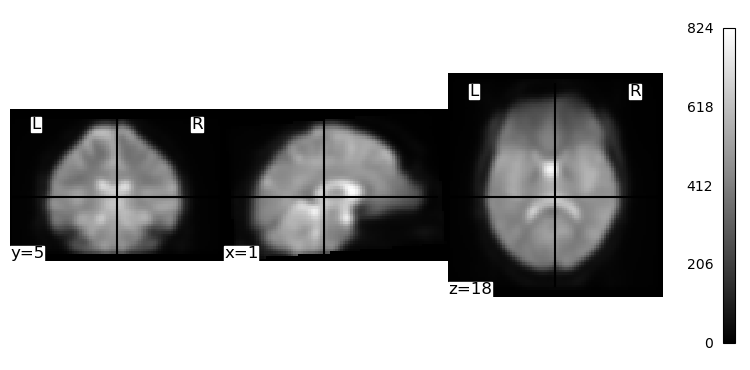

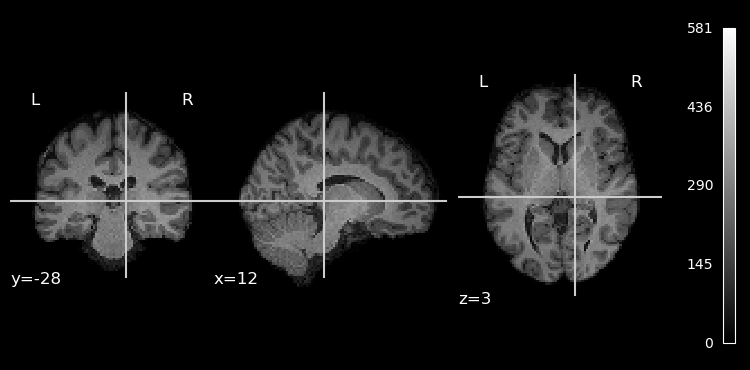

In [3]:
mean_img = image.mean_img('func/run01/*.nii')
plot_img(mean_img, colorbar=True, cbar_tick_format="%i", cmap="gray")

plot_anat('anat/wc0cs2018-08-05_10-17-102019-00001-00160-1.nii',
        colorbar=True, cbar_tick_format="%i")

show()

#### See Experiment Paradigm

In [4]:
import pandas as pd

events = pd.read_table('func/run01/events.tsv')
events.head(10)

,onset,duration,block,counterbalance,ChosenProbeColor,CorrectProbeColor,CurrentTask,LastITI,ProbeLoc,ProbeMatch,...,probeACC,probeStart,probert,response,runStart,scannerStart,stimFlip,stimStart,subject,trialStart
0,6.0,3.5,1,1,5,141,1,6.0,7,1,...,1,1634146.0,0.774408,1,1634145.0,1634139.0,1634145.0,1634145.0,103,1634145.0
1,10.5,3.5,1,1,2,121,1,6.0,5,1,...,1,1634151.0,0.880411,1,1634145.0,1634139.0,1634149.0,1634149.0,103,1634149.0
2,15.0,3.5,1,1,9,21,1,6.0,5,2,...,1,1634155.0,0.959108,2,1634145.0,1634139.0,1634154.0,1634154.0,103,1634153.0
3,19.5,3.5,1,1,1,21,1,6.0,2,1,...,1,1634160.0,0.863326,1,1634145.0,1634139.0,1634158.0,1634158.0,103,1634157.0
4,24.0,3.5,1,1,5,41,1,6.0,5,1,...,1,1634164.0,1.645432,1,1634145.0,1634139.0,1634163.0,1634163.0,103,1634162.0
5,28.5,3.5,1,1,2,1,1,6.0,9,2,...,1,1634169.0,0.796284,2,1634145.0,1634139.0,1634167.0,1634167.0,103,1634166.0
6,33.5,3.5,1,1,3,141,1,6.0,6,2,...,1,1634174.0,0.831825,2,1634145.0,1634139.0,1634172.0,1634172.0,103,1634171.0
7,38.5,3.5,1,1,1,81,1,6.0,9,1,...,1,1634179.0,0.615353,1,1634145.0,1634139.0,1634177.0,1634177.0,103,1634176.0
8,44.5,3.5,1,1,1,61,1,6.0,3,1,...,1,1634185.0,1.565718,1,1634145.0,1634139.0,1634183.0,1634183.0,103,1634181.0
9,50.0,3.5,1,1,3,21,1,6.0,5,1,...,1,1634190.0,0.630607,1,1634145.0,1634139.0,1634189.0,1634189.0,103,1634187.0


#### GLM Analysis

In [5]:
fmri_glm = FirstLevelModel(
    t_r=2,
    hrf_model="spm + derivative",
    smoothing_fwhm=0.6,
    drift_model="cosine",
    minimize_memory=False
    
)

fmri_glm = fmri_glm.fit(run01_img, events)

/Users/jennifer/anaconda3/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:129: UserWarning: 'trial_type' column not found in the given events data.
  warnings.warn(
/Users/jennifer/anaconda3/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: ProbeType, trialStart, msecProbeRT, CorrectProbeColor, runStart, probeACC, stimStart, correctResp, response, error, ChosenProbeColor, counterbalance, probeStart, ProbeMatch, block, scannerStart, CurrentTask, SeqStartTime, subject, LastITI, ProbeLoc, probert, chooseSequence, ThisITI, centralJitter, SetSize, stimFlip
  warnings.warn(


#### Plot Design Matrix for Single-Subject Analysis
The important part to note is the "dummy" and "dummy derivative", which denotes the activation of signal at each scan.

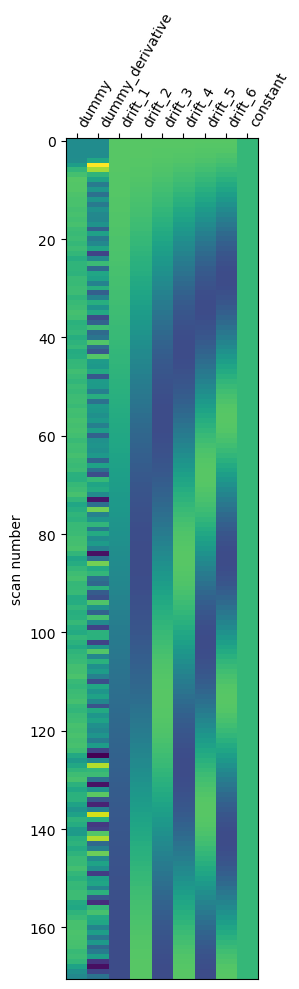

In [6]:
design_matrix = fmri_glm.design_matrices_[0]

plot_design_matrix(design_matrix)

show()

Plot the dummy and dummy derivative columns

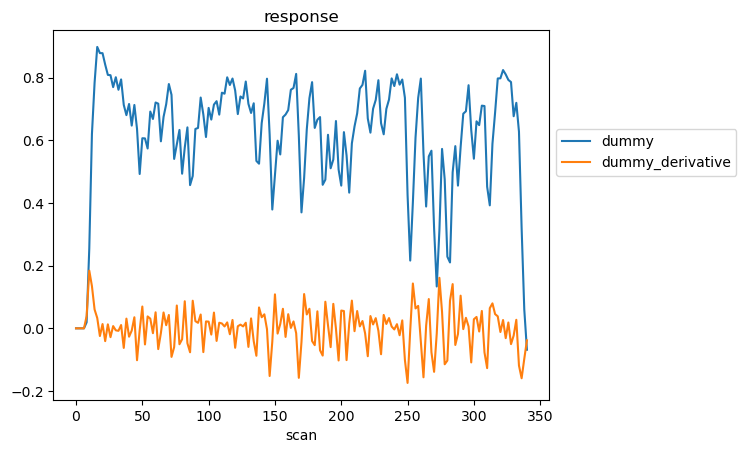

In [7]:
import matplotlib.pyplot as plt

plt.plot(design_matrix["dummy"])
plt.plot(design_matrix["dummy_derivative"])
plt.legend(['dummy', "dummy_derivative"], bbox_to_anchor=(1, 0.75))
plt.xlabel("scan")
plt.title("response")

show()

#### Locating Significant Voxels

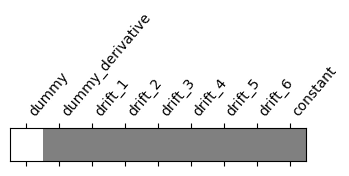

In [8]:
n_regressors = design_matrix.shape[1]
activation = np.zeros(n_regressors)
activation[0] = 1

plot_contrast_matrix(contrast_def=activation, design_matrix=design_matrix)
show()

Compute effect size (z-scored)

In [9]:
eff_map = fmri_glm.compute_contrast(activation, output_type="effect_size")
# t-statistic to z-scale 
z_map = fmri_glm.compute_contrast(activation, output_type="z_score")

Unthresholded plot

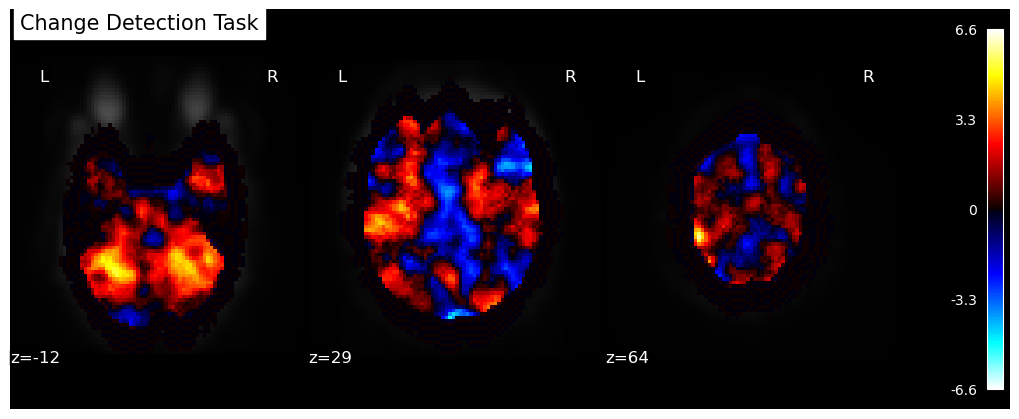

In [10]:
plotting_config = {
    "bg_img": mean_img,
    "display_mode": "z",
    "cut_coords": 3,
    "black_bg": True,
}
plot_stat_map(
    z_map,
    title="Change Detection Task",
    figure=plt.figure(figsize=(10, 4)),
    **plotting_config,
)
show()

Arbitrary Threshold

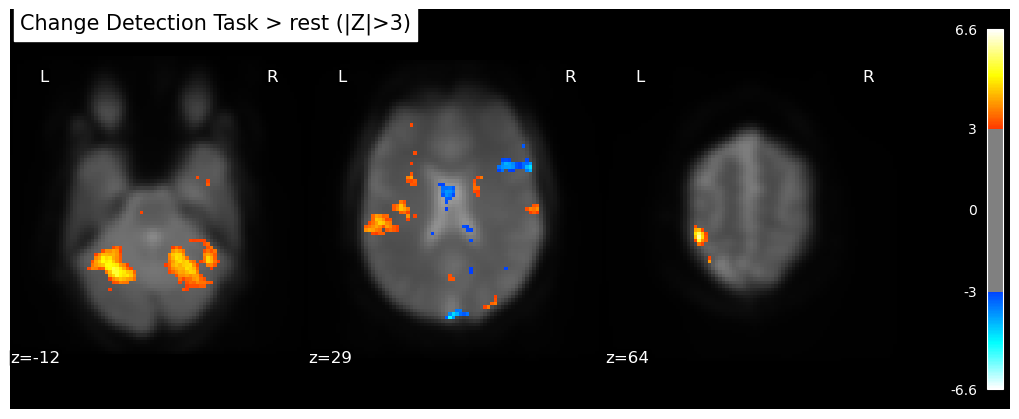

In [11]:
threshold_easy = 3
plot_stat_map(
    z_map,
    threshold=threshold_easy,
    title="Change Detection Task > rest (|Z|>3)",
    figure=plt.figure(figsize=(10, 4)),
    **plotting_config,
)
show()

Control False Positive Rate at 0.001 (0.1% chance of declaring an inactive voxel active)

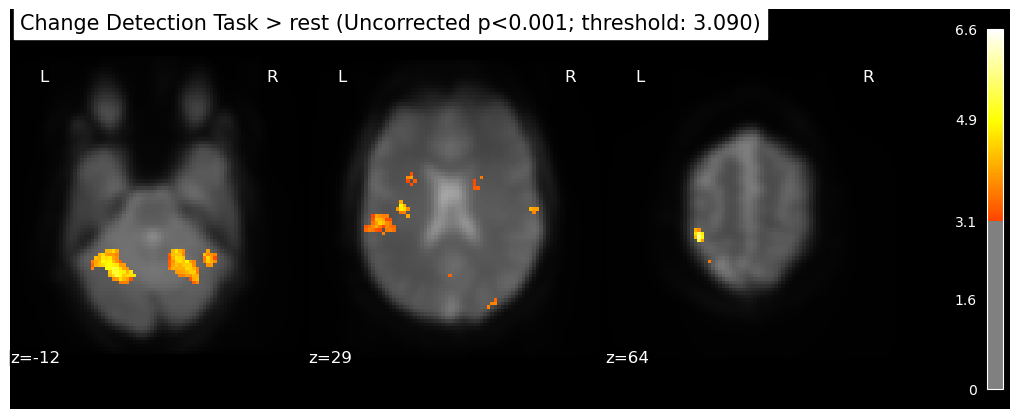

In [12]:
from nilearn.glm import threshold_stats_img

clean_map, threshold_difficult = threshold_stats_img(
    z_map,
    alpha=0.001,
    height_control="fpr", # false positive rate
    two_sided=False,  # using a one-sided test
)

plotting_config["cmap"] = "black_red"
plot_stat_map(
    clean_map,
    threshold=threshold_difficult,
    title=(
        "Change Detection Task > rest (Uncorrected p<0.001; "
        f"threshold: {threshold_difficult:.3f})"
    ),
    figure=plt.figure(figsize=(10, 4)),
    **plotting_config,
)
show()

FDR to 0.05 (5% chance of declaring inactive voxel active)

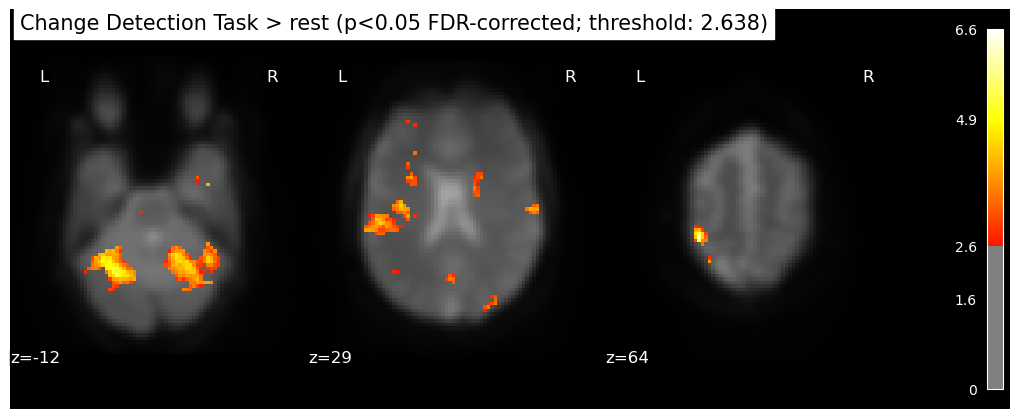

In [13]:
clean_map, threshold_medium = threshold_stats_img(
    z_map, alpha=0.05, height_control="fdr", two_sided=False
)
plot_stat_map(
    clean_map,
    threshold=threshold_medium,
    title=(
        "Change Detection Task > rest (p<0.05 FDR-corrected; "
        f"threshold: {threshold_medium:.3f})"
    ),
    figure=plt.figure(figsize=(10, 4)),
    **plotting_config,
)
show()

#### Now store the significant voxels in a dataframe (arbitrary, 0.05, 0.001)

In [14]:
from nilearn.reporting import get_clusters_table

table_easy = get_clusters_table(
    clean_map, stat_threshold=threshold_easy
)
table_easy.shape

(117, 6)

In [15]:
table_medium = get_clusters_table(
    clean_map, stat_threshold=threshold_medium
)
table_medium.shape

(161, 6)

In [16]:
table_difficult = get_clusters_table(
    clean_map, stat_threshold=threshold_difficult
)
table_difficult.shape

(108, 6)

In [17]:
from atlasreader import create_output
create_output(mean_img, cluster_extent=10, voxel_thresh=threshold_difficult) # saves info on each spatial cluster

The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data



##### Now plot the predicted signals for the top 6 most significant clusters

In [24]:
from sklearn.preprocessing import StandardScaler
# get the 6 largest clusters' max x, y, and z coordinates
coords = table_difficult.loc[range(1, 7), ["X", "Y", "Z"]].to_numpy()

# extract time series from each coordinate
masker = NiftiSpheresMasker(coords)
observed_timeseries = masker.fit_transform(run01_img)
predicted_timeseries = masker.fit_transform(fmri_glm.predicted[0])

scaler = StandardScaler()
observed_scaled = scaler.fit_transform(observed_timeseries)
predicted_scaled = scaler.fit_transform(predicted_timeseries)

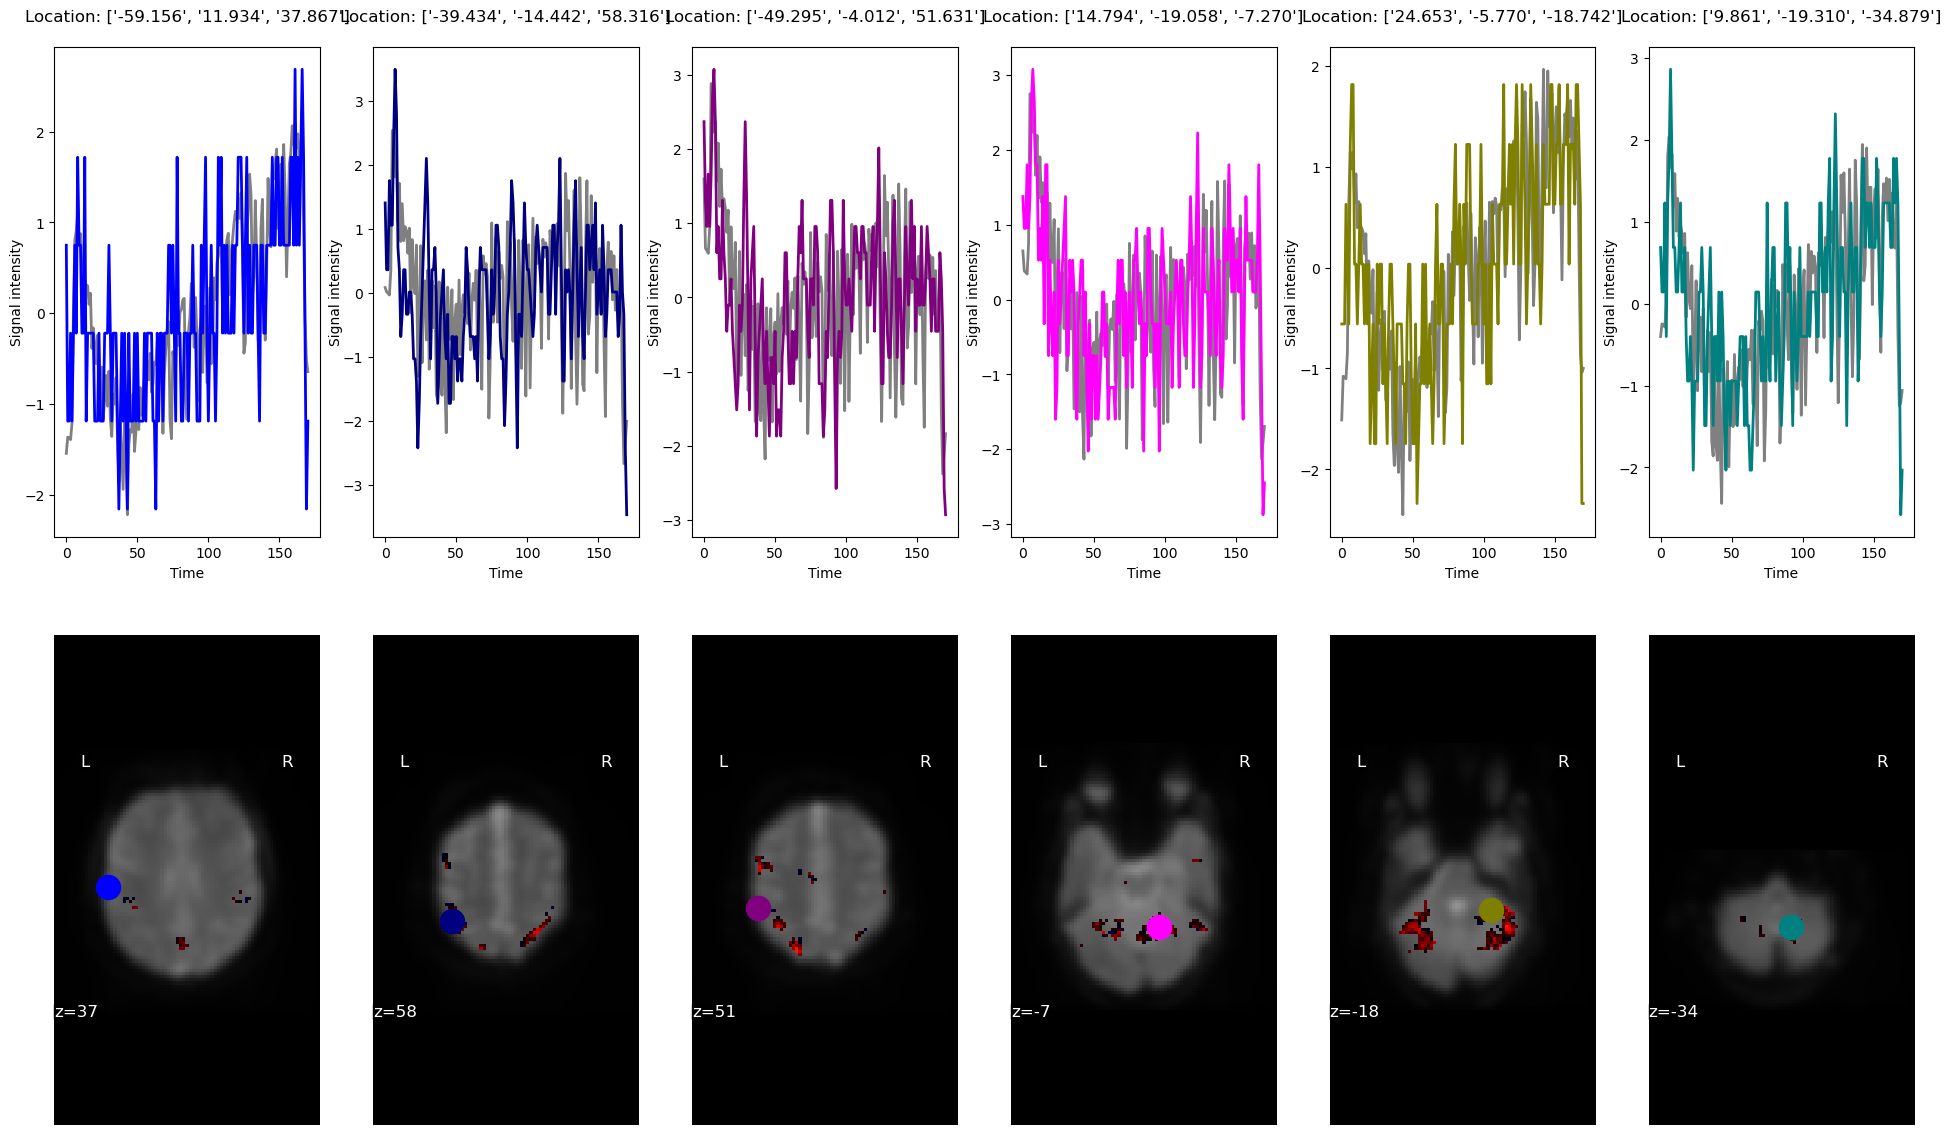

In [30]:
colors = ["blue", "navy", "purple", "magenta", "olive", "teal"]

# plot the time series and corresponding locations
fig1, axs1 = plt.subplots(2, 6)
for i in range(6):
    coord = [f"{value:.3f}" for value in coords[i]]
    axs1[0, i].set_title(f"Location: {coord}\n")
    axs1[0, i].plot(predicted_scaled[:, i], c="grey", lw=2)
    axs1[0, i].plot(observed_scaled[:, i], c=colors[i], lw=2)
   
    axs1[0, i].set_xlabel("Time")
    axs1[0, i].set_ylabel("Signal intensity", labelpad=0)
    
    roi_img = plot_stat_map(
        clean_map,
        cut_coords=[coords[i][2]],
        threshold=threshold_difficult,
        figure=fig1,
        axes=axs1[1, i],
        display_mode="z",
        colorbar=False,
        bg_img=mean_img,
    )
    roi_img.add_markers([coords[i]], colors[i], 300)
fig1.set_size_inches(24, 14)

show()

#### GLM2 from paper results, used for PFC localization

/Users/jennifer/anaconda3/lib/python3.11/site-packages/nilearn/plotting/img_plotting.py:1317: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  safe_get_data(stat_map_img, ensure_finite=True),


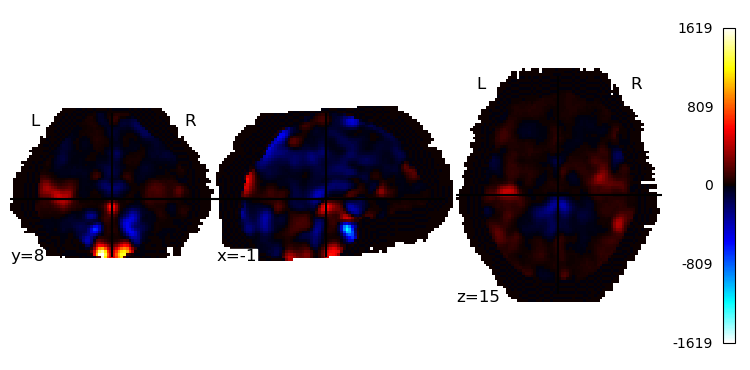

In [20]:
glm2 = image.mean_img('results/GLM2/beta*.nii')
plot_stat_map(glm2, colorbar=True, cbar_tick_format="%i", bg_img=None)

#### Plot the Actual Signals vs the GLM Predicted Signals

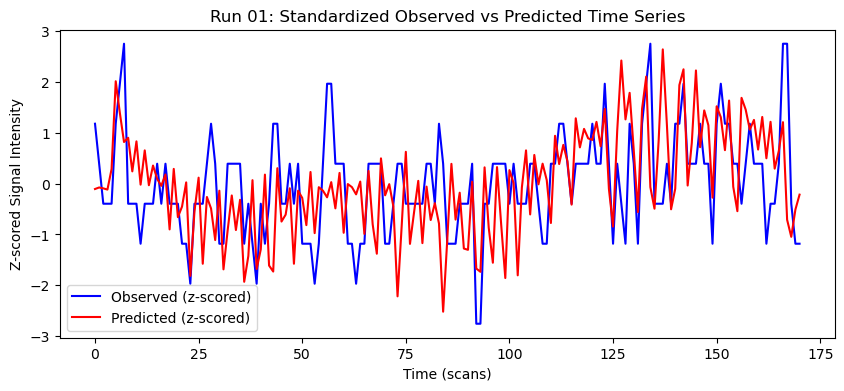

In [21]:
roi_coords = [(30, -10, 50)]
masker = NiftiSpheresMasker(roi_coords, radius=0, t_r=2.0)
concat_run = concat_imgs(os.path.join('func', 'run01', '*.nii'), auto_resample=True)

observed_timeseries = masker.fit_transform(concat_run)
predicted_timeseries = masker.fit_transform(fmri_glm.predicted[0]) 

scaler = StandardScaler()
observed_scaled = scaler.fit_transform(observed_timeseries)
predicted_scaled = scaler.fit_transform(predicted_timeseries)

plt.figure(figsize=(10, 4))
plt.plot(observed_scaled, label='Observed (z-scored)', color='blue')
plt.plot(predicted_scaled, label='Predicted (z-scored)', color='red')
plt.legend()
plt.title(f"Run 01: Standardized Observed vs Predicted Time Series")
plt.xlabel("Time (scans)")
plt.ylabel("Z-scored Signal Intensity")
plt.show()


Scatterplot to visualize each scan as a data point

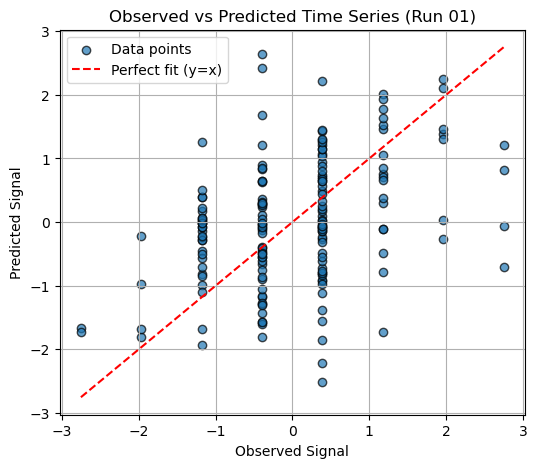

In [22]:
plt.figure(figsize=(6, 5))
plt.scatter(observed_scaled, predicted_scaled, alpha=0.7, edgecolor='k', label="Data points")
plt.plot([observed_scaled.min(), observed_scaled.max()],
            [observed_scaled.min(), observed_scaled.max()],
            color="red", linestyle="--", label="Perfect fit (y=x)")
plt.title("Observed vs Predicted Time Series (Run 01)")
plt.xlabel("Observed Signal")
plt.ylabel("Predicted Signal")
plt.legend()
plt.grid(True)
plt.show()

#### Plot with normalized data 
We have been working with the data with the prefix `srraf`, and according to the SPM12 preprocessing pipeline, if the data has been normalized, it should have the prefix `w`. 

In [25]:
labServer_filePath = '/Volumes/kiyonaga/MIPS/fMRI/subjects/MIPS_103/func/run01/wrraf*.nii'
normOneRun = image.load_img(labServer_filePath)
norm_mean = image.mean_img(labServer_filePath)
print(normOneRun.shape) # x, y, z, number of scans

(79, 95, 79, 171)


In [26]:
norm_glm = FirstLevelModel(
    t_r=2,
    hrf_model="spm + derivative",
    smoothing_fwhm=0.6,
    drift_model="cosine",
    minimize_memory=False
    
)

norm_glm = norm_glm.fit(normOneRun, events)

/Users/jennifer/anaconda3/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:129: UserWarning: 'trial_type' column not found in the given events data.
  warnings.warn(
/Users/jennifer/anaconda3/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: SetSize, centralJitter, ThisITI, CurrentTask, runStart, scannerStart, LastITI, trialStart, block, probert, ProbeMatch, ProbeType, response, msecProbeRT, error, SeqStartTime, stimStart, probeACC, stimFlip, ProbeLoc, probeStart, counterbalance, correctResp, subject, ChosenProbeColor, CorrectProbeColor, chooseSequence
  warnings.warn(


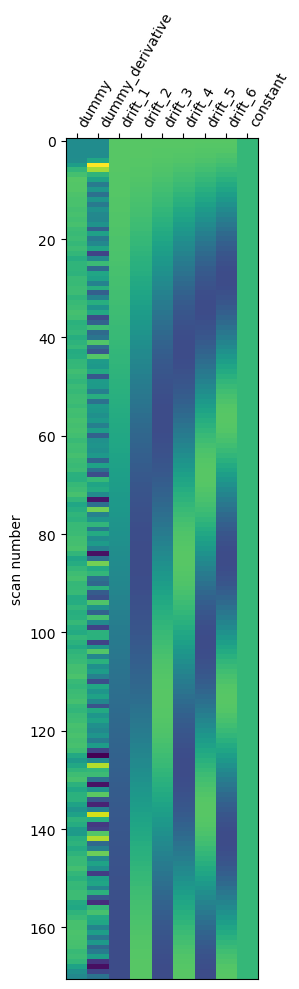

In [27]:
norm_design_matrix = norm_glm.design_matrices_[0]

plot_design_matrix(norm_design_matrix)

show()

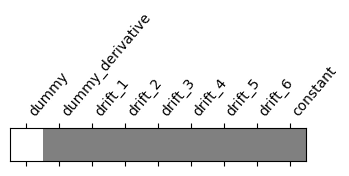

In [28]:
norm_n_regressors = norm_design_matrix.shape[1]
norm_activation = np.zeros(norm_n_regressors)
norm_activation[0] = 1

plot_contrast_matrix(contrast_def=norm_activation, design_matrix=norm_design_matrix)
show()

In [29]:
norm_eff_map = norm_glm.compute_contrast(norm_activation, output_type="effect_size")
# t-statistic to z-scale 
norm_z_map = norm_glm.compute_contrast(norm_activation, output_type="z_score")

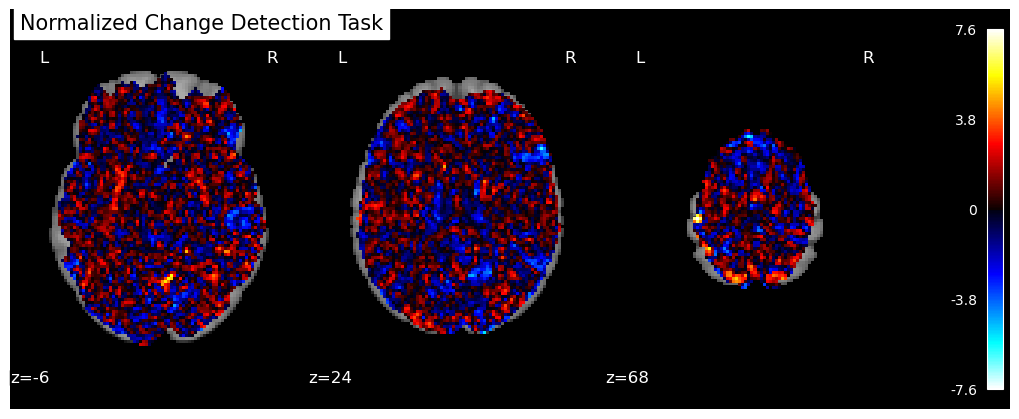

In [30]:
plotting_config = {
    "display_mode": "z",
    "cut_coords": 3,
    "black_bg": True,
}
plot_stat_map(
    norm_z_map,
    title="Normalized Change Detection Task",
    figure=plt.figure(figsize=(10, 4)),
    **plotting_config,
)
show()

Compare to the expected GLM results:

/Users/jennifer/anaconda3/lib/python3.11/site-packages/nilearn/plotting/img_plotting.py:1317: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  safe_get_data(stat_map_img, ensure_finite=True),


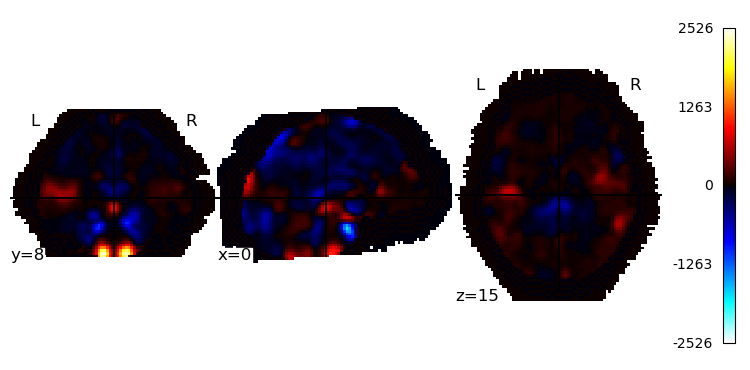

In [31]:
glm1 = image.mean_img('results/GLM1/beta*.nii')
plot_stat_map(glm1, colorbar=True, cbar_tick_format="%i", bg_img=None)

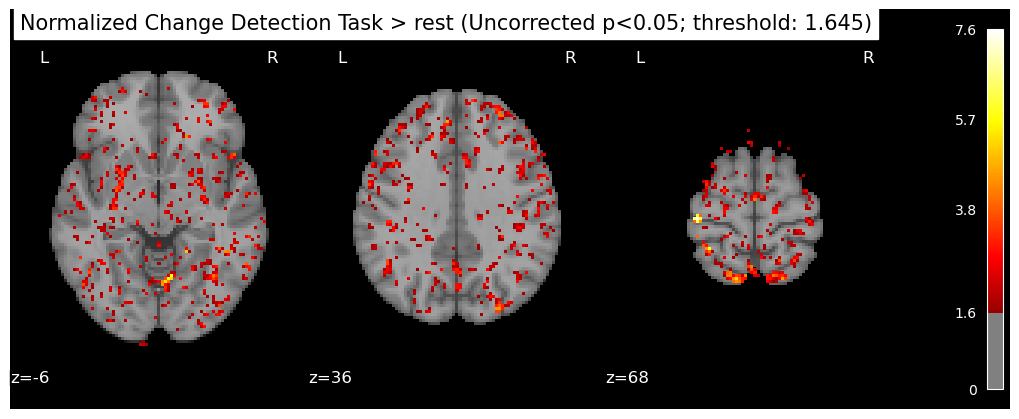

In [32]:
norm_clean_map, norm_threshold = threshold_stats_img(
    norm_z_map,
    alpha=0.05,
    height_control="fpr", # false positive rate
    two_sided=False,  # using a one-sided test
)

plotting_config["cmap"] = "black_red"
plot_stat_map(
    norm_clean_map,
    threshold=norm_threshold,
    title=(
        "Normalized Change Detection Task > rest (Uncorrected p<0.05; "
        f"threshold: {norm_threshold:.3f})"
    ),
    figure=plt.figure(figsize=(10, 4)),
    **plotting_config,
)
show()

Seems like even when we used the normalized image, it doesn't fit well to the template space. For Quarter 2, we plan on completely re-doing the preprocessing for the data.